In [24]:
import numpy as np
import time
import matplotlib.pyplot as plt
import string
import pybobyqa
from tqdm import tqdm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from wolframclient.evaluation import WolframLanguageSession
import scipy.optimize
from mpl_axes_aligner import align

font = {'weight': 'bold', 'family': 'DejaVu Sans'}
plt.rc('text', usetex = True)
plt.rc('font', **font)
plt.rcParams['font.size'] = 24

def save_fig(figs, figname):

    if (type(figs) is list):
        for q, fig in enumerate(figs):
            fig.savefig('%s_%d.svg' % (figname, q), bbox_inches = 'tight')
            fig.savefig('%s_%d.pdf' % (figname, q), bbox_inches = 'tight')
            fig.savefig('%s_%d.png' % (figname, q), bbox_inches = 'tight', dpi = 300)
    else:
        figs.savefig('%s.svg' % (figname), bbox_inches = 'tight')
        figs.savefig('%s.pdf' % (figname), bbox_inches = 'tight')
        figs.savefig('%s.png' % (figname), bbox_inches = 'tight', dpi = 300)
      

In [25]:
session = WolframLanguageSession()


session.evaluate('P1[sig_, m_, sigv_, r0_] := Exp[-m]*(r0 - sig) + \
                       Integrate[Exp[-m*(1 - ((x - (r0 - sig))/(2*sig)))], {x, r0 - sig, r0 + sig}] \
                       + (sigv - (r0 + sig))')

session.evaluate('P2[sig_, m_, sigv_, r0_] := Exp[-m]*(r0 - sig) + \
                       Integrate[Exp[-m*(1 - ((x - (r0 - sig))/(2*sig)))] ,  {x, r0 - sig, sigv}]')
session.evaluate('P3[sig_, m_, sigv_, r0_] := Exp[-m]*sigv')
session.evaluate('P4[sig_, m_, sigv_, r0_] := Exp[-m*(1 - (1 - r0/sig))]*(sig - r0) + \
                      Integrate[Exp[-m*(1 - (1 + (x - sig - r0)/(2*sig)))], {x, sig - r0, sig + r0}] \
                      + (sigv - (sig + r0))')
session.evaluate('P5[sig_, m_, sigv_, r0_] := Exp[-m*(1 - (1 - r0/sig))]*(sig - r0) + \
                      Integrate[Exp[-m*(1 - (1 + (x - sig - r0)/(2*sig)))], {x, sig - r0, sigv} ]')
session.evaluate('P6[sig_, m_, sigv_, r0_] := Exp[-m*(1 - (1 - r0/sig))]*(sigv)')
session.evaluate('P7[sig_, m_ , sigv_, r0_] := Exp[-m]*r0 + (sigv - r0 )')

session.evaluate('Fdown[sig_, m_, sigv_, r0_] := Piecewise[{{P1[sig, m, sigv, r0], r0 + sig < sigv}, \
                         {P2[sig, m, sigv, r0], r0 - sig < sigv <= r0 + sig}, \
                         {P3[sig, m, sigv, r0], sigv  <= r0 - sig}}]')
session.evaluate('Fup[sig_, m_, sigv_, r0_] := Piecewise[{{P4[sig, m, sigv, r0], sig + r0 < sigv}, \
                       {P5[sig, m, sigv, r0], sig - r0 < sigv <= sig + r0}, \
                       {P6[sig, m, sigv, r0], sigv <= sig - r0}}]')
session.evaluate('Fsing[sig_, m_, sigv_, r0_] := Piecewise[{{P7[sig, m, sigv, r0], r0 < sigv}, \
                         {P8[sig, m, sigv, r0], sigv <= r0}}]')


session.evaluate('F[sig_, m_, sigv_, r0_, phi_, kappa_,  psi_] := \
                 (1/sigv)*Piecewise[{{Fup[sig, m, sigv, r0], sig > r0}, \
                 {Fdown[sig, m, sigv, r0], 0 < sig <= r0}, \
                 {Fsing[sig, m, sigv, r0], sig == 0 }}]*phi + \
                 kappa*m + psi*(1 - Exp[-m])')

F = session.function('F[]')

session.evaluate('Pmiss[sig_, m_, sigv_, r0_, phi_, kappa_,  psi_] := \
                 N[(1/sigv)*Piecewise[{{Fup[sig, m, sigv, r0], sig > r0}, \
                 {Fdown[sig, m, sigv, r0], 0 < sig <= r0}, \
                 {Fsing[sig, m, sigv, r0], sig == 0 }}]]')


Pmiss = session.function('Pmiss')

session.evaluate('Fnum[sig_, m_, sigv_, r0_,  phi_, kappa_, psi_] := N[F[sig, m, sigv, r0,  phi, kappa, psi]]')

Fnum = session.function('Fnum')

session.evaluate('DFsig[sig_, m_, sigv_, r0_, phi_, kappa_,  psi_] = \
                  D[F[sig, m, sigv, r0, phi, kappa, psi], sig]')

session.evaluate('DFm[sig_, m_, sigv_, r0_, phi_, kappa_,  psi_] = \
                  D[F[sig, m, sigv, r0, phi, kappa, psi], m]')


session.evaluate('FRoot[r0_, phi_, kappa_,  psi_] := \
                  FindRoot[DFm[0.0, 0.0, sigv, r0, phi, kappa,  psi], {sigv, 1.05}][[1]][[2]]')

FRoot = session.function('FRoot')


session.evaluate('G[sigv_,  phi_, kappa_, psi_] := \
                  Piecewise[{{Minimize[{F[sig, m, sigv, 1.0,  phi, kappa, psi], \
                  2*sigv >= sig >= 0, m >= 0}, {sig, m}][[2]][[1]][[2]], \
                  sigv >= 1.0}, {0, sigv < 1.0}}]')

G = session.function('G')

session.evaluate('H[sigv_,  phi_, kappa_, psi_] := \
                  Minimize[{F[sig, m, sigv, 1.0,  phi, kappa, psi], \
                  2*sigv >= sig >= 0, m >= 0},  {sig, m}][[2]][[2]][[2]]')

H = session.function('H')


100%|██████████| 80/80 [00:00<00:00, 133.58it/s]
posx and posy should be finite values


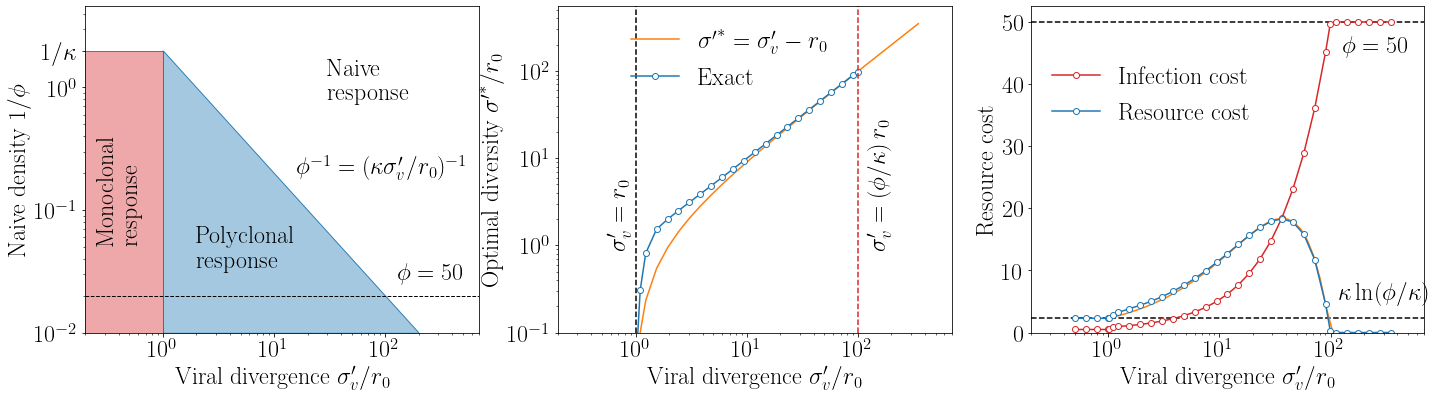

In [26]:
plt.rcParams['figure.figsize'] = (3*8, 6)


fig, (ax1, ax3, ax2) = plt.subplots(nrows = 1,
                                    ncols = 3, sharex = True)

# This is the canonical figure: exactly the size of a column in a latex document
# To reproduce same plot size in any other type of subplots, use set_size(5.48, 4.54, ax)


r0 = 1
kappa = 0.5
psi = 0

params = np.logspace(np.log10(0.01), np.log10(1/(0.505)), 80)
nparams = len(params)

sigvMCPC = np.ones(nparams)
sigvPCN = np.zeros(nparams)
sigvM = np.zeros(nparams)

for i in tqdm(range(nparams)):
    sigvPCN[i] = FRoot(r0, 1/params[i], kappa, psi)

    
a = np.copy(sigvMCPC)
b = np.copy(sigvPCN)

aex = a[a < b]
bex = b[a < b]
pex = params[a < b]

mc = np.concatenate((aex, np.zeros(1)))
mc_pm = np.concatenate((pex,
                        np.array([pex[-1]])))
            

pc = np.concatenate((bex,
                     np.array([aex[-1]])))
pc_pm = np.concatenate((pex,
                        np.array([pex[-1]])))


ax1.fill_betweenx(pc_pm[:-1], mc[:-1], pc[:-1], alpha = 0.4, color = 'C0')
ax1.plot(pc, pc_pm, '-', linewidth = 0.7, color = 'C0')
ax1.fill_betweenx(mc_pm[:-1], 0, mc[:-1], alpha = 0.4, color = 'C3')
ax1.plot(mc, mc_pm, '-', linewidth = 0.7, color = 'C3')

ax1.set_ylabel(r'Naive density $1/\phi$')
ax1.set_xlabel(r'Viral divergence $\sigma_v^{\prime}/r_0$')

ax1.text(16, 2e-1, r'$\phi^{-1} = (\kappa \sigma_v^{\prime}/r_0)^{-1}$')
ax1.set_xscale('log')
ax1.set_yscale('log')


(ymin, ymax) = ax1.get_ylim()

ax1.text(0.25, 0.055, 'Monoclonal\nresponse', 
         rotation = 90)
ax1.text(2, 0.034, 'Polyclonal\nresponse')
ax1.text(30, 0.8, 'Naive\nresponse')
ax1.axhline(y = 1/50, linestyle = '--', color = 'k', linewidth = 1)
ax1.annotate(r'$\phi = 50$', (130, 1/50 + 0.007))

fig.canvas.draw()

yticks = list(ax1.get_yticks())
yticks_labels = [w.get_text() for w in ax1.get_yticklabels()]

yticks_labels += [r'$1/\kappa$']
yticks += [1/kappa]

ax1.set_yticks(yticks)
ax1.set_yticklabels(yticks_labels)

ax1.set_ylim([0.01, ymax + 2])
ax1.set_xlim([0.2, 700])
phi = 50
kappa = 0.5
psi = 0.0
r0 = 1
V0 = r0


sigvar = np.logspace(np.log10(0.5), np.log10(350), 30)
sigvar = np.sort(np.append(sigvar, np.array([1.02, 1.1, r0*(phi/kappa)-0.5])))
nsigv = len(sigvar)

numar = np.zeros(nsigv)
sigar = np.zeros(nsigv)
avar = np.zeros(nsigv)

for i in range(nsigv):
    
    sigv = sigvar[i]
    
    f_0 = Fnum(4, 0, sigv, r0, phi, kappa, psi)

    sigar[i] = G(sigv, phi, kappa, psi)
    numar[i] = H(sigv, phi, kappa, psi)
    
    if(sigar[i] <= 0):
        avar[i] = Pmiss(0.0001, numar[i], sigv, r0, phi, kappa, psi)
        f_alg = Fnum(0.0001, 0, sigv, r0, phi, kappa, psi)
    else:
        avar[i] = Pmiss(sigar[i], numar[i], sigv, r0, phi, kappa, psi)
        f_alg = Fnum(sigar[i], numar[i], sigv, r0, phi, kappa, psi)
   
    if(f_0 < f_alg):
        sigar[i] = 0
        numar[i] = 0
    


xtheory = np.logspace(np.log10(np.min(sigvar)), np.log10(np.max(sigvar)), 50)
mtheory_detailed = ((xtheory)/V0)*np.log((phi/kappa)*(V0/(xtheory)))
mtheory_detailed[mtheory_detailed < 0] = 0


      
ax2.set_ylabel(r'Cost')

ax2.axhline(y = phi, 
                linestyle = '--', 
                color = 'k',
                label = r'$\phi$')

ax2.axhline(y = kappa*np.log(phi/kappa), 
            linestyle = '--', 
            color = 'k',
            label = r'$\kappa \ln (\phi/\kappa)$')

ax2.plot(xtheory[xtheory > r0], kappa*mtheory_detailed[xtheory > r0], '-', color = 'C1')
p0, = ax2.plot(sigvar, avar*phi, 'o-', markersize = 6, markerfacecolor = 'w', 
                    markeredgecolor = 'C3',
                    label = r'Infection cost', color = 'C3')
p1, = ax2.plot(sigvar, numar*kappa, 'o-',
               markersize = 6, markerfacecolor = 'w', 
               markeredgecolor = 'C0',
               label = r'Resource cost', color = 'C0')

ax2.legend(handles = [p0, p1], frameon = False, 
           loc = 'upper left',
           bbox_to_anchor =  (0.0, -0.11, 1., 1.),
           bbox_transform = ax2.transAxes)


ax2.annotate(r'$\phi = 50$', (130, phi - 5), xycoords = 'data')
ax2.annotate(r'$\kappa \ln(\phi/\kappa)$', (120, kappa*np.log(phi/kappa) + 3), xycoords = 'data')



ax2.set_ylabel(r'Resource cost')
ax2.set_xlabel(r'Viral divergence $\sigma_v^{\prime}/r_0$')
ax2.set_xscale('log')
ax2.set_ylim(ymin = 0)

sigar[sigvar > (phi*V0/kappa)] = 0

ax3.plot(sigvar, sigvar - r0, color = 'C1',
         label = r'${\sigma^\prime}^* = \sigma_v^{\prime} - r_0$')

ax3.plot(sigvar, sigar, 
         'o-',  markersize = 6, markerfacecolor = 'w', 
         markeredgecolor = 'C0',
         color = 'C0', 
         label = r'Exact',
         linestyle = '-')

ax3.axvline(x = ((phi*V0/kappa)),
            linestyle = '--',  
            color = 'C3')

ax3.axvline(x = V0, 
            linestyle = '--', 
            color = 'k')


ax3.legend(frameon = False,
           loc = 'upper left',
           bbox_to_anchor =  (+0.13, 0.0, 1., 1.),
           bbox_transform = ax3.transAxes)
ax3.set_ylabel(r'Optimal diversity ${\sigma^\prime}^{*}/r_0$')
ax3.set_xlabel(r'Viral divergence $\sigma_v^{\prime}/r_0$')
ax3.set_xscale('log')
ax3.set_yscale('log', nonpositive = 'mask')
ax3.set_ylim([1e-1, 550])
ax3.annotate(r'$\sigma_v^{\prime} = r_0$', (r0 - 0.45, 1), rotation = 'vertical')
ax3.annotate(r'$\sigma_v^{\prime} = \left(\phi /\kappa\right) r_0$', ((phi/kappa)*r0 + 20, 1), rotation = 'vertical')

plt.show()

save_fig(fig, 'fig2')

session.terminate()